# Pietroiusti et al 2023 - GCM model evaluation - PERSIANN fillnan

Evaluate how GCMs represent precip over Lake Victoria Basin, compared to PERSIANN precip data 1985-2020 (version 3)

1) spatial pattern

2) seasonal cycle

Rosa Pietroiusti July 2023 update 

In [1]:
# in sidebar: (import SciPy bundle, matplotlib), regionmask, Cartopy, netcdf4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
%matplotlib inline
import os, glob 
import math

In [2]:
import xarray as xr
import geopandas as gpd
import regionmask as regionmask


/apps/brussel/CO7/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
import netCDF4

In [8]:
vsc_vo_data = os.environ['VSC_DATA_VO_USER']

# change current working directory to GCM hist simulations
os.chdir(vsc_vo_data)
os.chdir('Thesis/ISIMIP3b/hist') 

# or if you want hist-rcp370 
os.chdir(vsc_vo_data)
os.chdir('Thesis/ISIMIP3b/hist-rcp70') 

# print GCM directory and folders in it 
inDIR = os.getcwd()
print(inDIR)
GCMs = sorted(os.listdir(os.curdir), key=str.casefold) # sort case-insensitive
print(GCMs)

#observations
obsDIR = os.path.join(vsc_vo_data, 'Thesis/PERSIANN')
obsFILE = os.path.join(obsDIR, 'PERSIANN-CDR_v01r01_1983_2020_remapped_owngrid_reorder_timelatlon.nc')
if os.path.exists(obsFILE) is False: 
    print('missing observational PERSIANN file!') # check the file exists

fig_path = os.path.join(vsc_vo_data, 'Thesis/ISIMIP3b/figs')


/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70
['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']


## Part 1 : spatial pattern

Open the observational precipitation dataset and each of the (cropped, reprojected) GCM datasets (with negative values replaced by zeros) and compare: 

1) Yearly accumulation mean spatial pattern 1985-2020

In [17]:
ncfile = obsFILE
var = 'precipitation'

# Open dataset and get key information - cut to 1985-2020
with xr.open_dataset(ncfile, engine='netcdf4') as ds:
    print(str(list(ds.keys())))
    print(str(list(ds.dims)))
    ds_dims = list(ds.dims) # time,lon, lat
    ds_varnames = list(ds.keys()) # get names of variables precipitation
    PERSIANN_raw = ds[str(var)]#.sel(time=slice("1985-01-01", "2020-01-02")) 
    PERSIANN_zero = PERSIANN_raw.where(PERSIANN_raw > 0, 0) # original dataset kept when true, condition, value when false

['precipitation']
['time', 'lat', 'lon']


In [18]:
PERSIANN_raw

<xarray.DataArray 'precipitation' (time: 13880, lat: 130, lon: 130)>
array([[[ 9.452342,  9.840559, ...,  6.466789,  6.469564],
        [11.110031, 11.868464, ...,  4.563325,  4.565995],
        ...,
        [ 1.563024,  1.70524 , ...,  0.      ,  0.      ],
        [ 1.564212,  1.706649, ...,  0.      ,  0.      ]],

       [[ 8.476215,  8.965446, ...,  7.152301,  7.155304],
        [ 8.338582,  8.856666, ...,  5.402614,  5.405141],
        ...,
        [ 5.141162,  4.482648, ...,  0.      ,  0.      ],
        [ 5.140357,  4.480447, ...,  0.      ,  0.      ]],

       ...,

       [[ 5.225131,  4.777242, ...,  1.818949,  1.818282],
        [ 6.129532,  6.023773, ...,  2.459416,  2.45869 ],
        ...,
        [ 0.853929,  1.052054, ...,  0.      ,  0.      ],
        [ 0.854076,  1.052049, ...,  0.      ,  0.      ]],

       [[ 6.089502,  6.747181, ..., 10.976821, 10.980453],
        [ 5.878462,  6.724365, ...,  8.983538,  8.986399],
        ...,
        [ 0.877349,  0.635342, ..., 16.775064, 16.771769],
        [ 0.877216,  0.635135, ..., 16.77376 , 16.770464]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1983-01-01 1983-01-02 ... 2020-12-31
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38
Attributes:
    standard_name:  precipitation_amount
    long_name:      NOAA Climate Data Record of PERSIANN-CDR daily precipitation
    units:          mm
    cell_method:    sum

In [19]:
PERSIANN_raw.min(), PERSIANN_raw.max(), PERSIANN_raw.mean(), PERSIANN_zero.min(), PERSIANN_zero.max(), PERSIANN_zero.mean()

(<xarray.DataArray 'precipitation' ()>
 array(-0.05060908),
 <xarray.DataArray 'precipitation' ()>
 array(134.96243286),
 <xarray.DataArray 'precipitation' ()>
 array(3.4138496, dtype=float32),
 <xarray.DataArray 'precipitation' ()>
 array(0.),
 <xarray.DataArray 'precipitation' ()>
 array(134.96243286),
 <xarray.DataArray 'precipitation' ()>
 array(3.3108118, dtype=float32))

In [20]:
# Mean maps 
climato_start = 1985
climato_end = 2020 # 2014 # when the GCM simulations hist stop

# mm/day
PERSIANN_climato = PERSIANN_zero.sel(time=slice('{}-01-01'.format(climato_start), '{}-12-31'.format(climato_end)))
PERSIANN_mean_d = PERSIANN_climato.mean('time')

# mm/yr 
PERSIANN_year = PERSIANN_climato.resample(time='Y', label='left').sum() # yearly acc
PERSIANN_mean_yr = PERSIANN_year.mean('time')

# mm/mo
PERSIANN_mo = PERSIANN_climato.resample(time='M', label='left').sum() # monthly acc
PERSIANN_mean_mo = PERSIANN_mo.mean('time')


In [21]:
def get_yearly_mean(fileDIR, var, start, end):
    with xr.open_dataset(fileDIR, engine='netcdf4', decode_coords="all") as ds:
            data = ds[str(var)]
            data_year = data.sel(time=slice('{}-01-01'.format(start), '{}-12-31'.format(end))).resample(time='Y', label='left').sum()
            data_year_mean = data_year.mean('time')
            
            if data.units == 'kg m-2 s-1': 
                print('units are kg m-2 s-1, converting them to kg m-2 d-1')
                data_year_mean = data_year_mean * 60 * 60 * 24
            else:
                print(data.units)
                
    return data_year_mean

def get_yearly_mean_noneg(fileDIR, var, start, end):
    with xr.open_dataset(fileDIR, engine='netcdf4', decode_coords="all") as ds:
            data = ds[str(var)]
            data = data.sel(time=slice('{}-01-01'.format(start), '{}-12-31'.format(end))) # slice
            data = data.where(data > 0, 0) # remove neg
            data_year = data.resample(time='Y', label='left').sum() # resample
            data_year_mean = data_year.mean('time') # mean
            
            if data.units == 'kg m-2 s-1': 
                print('units are kg m-2 s-1, converting them to kg m-2 d-1')
                data_year_mean = data_year_mean * 60 * 60 * 24
            else:
                print(data.units)
            
    return data_year_mean




In [22]:
GCM_raw = {}
GCM_zero = {}
var = 'pr'
start = 1985 # to cfr w persiann
end = 2020 # 2014

for i in range(len(GCMs)):
    GCM = GCMs[i]
    fileDIR=glob.glob(os.path.join(inDIR, GCM, '*_pr_owngrid*1850_{}.nc'.format(end)))[0]
    print(fileDIR)
    GCM_raw["{}".format(GCM)] = get_yearly_mean(fileDIR, var, start, end)    
    GCM_zero["{}".format(GCM)] = get_yearly_mean_noneg(fileDIR, var, start, end)  

/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/CanESM5/CanESM5_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/CNRM-CM6-1/CNRM-CM6-1_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/GFDL-ESM4/GFDL-ESM4_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/IPSL-CM6A-LR/IPSL-CM6A-LR_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
units are kg m-2 s-1, converting them to kg 

In [23]:
GCM_raw[GCMs[0]]

<xarray.DataArray 'pr' (lat: 130, lon: 130)>
array([[1187.3807 , 1175.2205 , 1175.19   , ...,  682.7013 ,  682.61884,
         682.5366 ],
       [1205.3027 , 1187.7065 , 1187.6733 , ...,  715.5647 ,  715.47424,
         715.3836 ],
       [1205.2827 , 1187.6664 , 1187.6328 , ...,  715.56464,  715.4741 ,
         715.3835 ],
       ...,
       [2126.6829 , 2086.0344 , 2085.9395 , ...,  266.05493,  266.2773 ,
         266.49963],
       [2127.0142 , 2085.9155 , 2085.8206 , ...,  266.0617 ,  266.28406,
         266.50638],
       [2127.3452 , 2085.7969 , 2085.702  , ...,  266.06848,  266.2908 ,
         266.5131 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 28.0 28.07 28.13 28.2 ... 36.19 36.26 36.32 36.38
  * lat      (lat) float64 -5.5 -5.435 -5.37 -5.305 ... 2.69 2.755 2.82 2.885

In [24]:
# maybe better put them all in array not in a dictionary ??

for i in range(6):
    print(GCMs[i])
    print(GCM_raw[GCMs[i]].max().values)
    
print(PERSIANN_mean_yr.max())

CanESM5
2127.34521484375
CNRM-CM6-1
2041.9287109375
GFDL-ESM4
2013.883544921875
IPSL-CM6A-LR
2036.5323486328125
MIROC6
2061.06494140625
MRI-ESM2-0
2096.15771484375
<xarray.DataArray 'precipitation' ()>
array(2838.63647461)


In [25]:
for i in range(6):
    print(GCMs[i])
    print(GCM_raw[GCMs[i]].min().values)
    
print(PERSIANN_mean_yr.min())

CanESM5
265.36749267578125
CNRM-CM6-1
216.71142578125
GFDL-ESM4
246.09457397460938
IPSL-CM6A-LR
247.56427001953125
MIROC6
236.8291015625
MRI-ESM2-0
230.65159606933594
<xarray.DataArray 'precipitation' ()>
array(287.63903809)


In [26]:
def plot_map(ax, data, title, cmap, levels, label, left=True, bottom=True, extend='neither'):
    gl = ax.gridlines(draw_labels=True,x_inline=False,y_inline=False, linewidth=0.8, color='gray', alpha=0.6, linestyle='dotted')
    gl.right_labels = False
    gl.top_labels = False
    if left is False:
        gl.left_labels = False
    if bottom is False:
        gl.bottom_labels = False
    plot = ax.contourf(data.lon, data.lat, data,  cmap=cmap, levels=levels,  transform=ccrs.PlateCarree(), extend=extend)
    ax.set_title(title, loc = 'left', size=12 )
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, facecolor="none", edgecolor='black', linewidth=0.8 )
    return plot, cmap

def plot_basin(ax, col):
    basin_shp.boundary.plot(ax=ax, edgecolor=col, linewidth=1.5, label='basin')

    # Character range function
def range_char(start, stop):
    return (chr(n) for n in range(ord(start), ord(stop) + 1))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
        

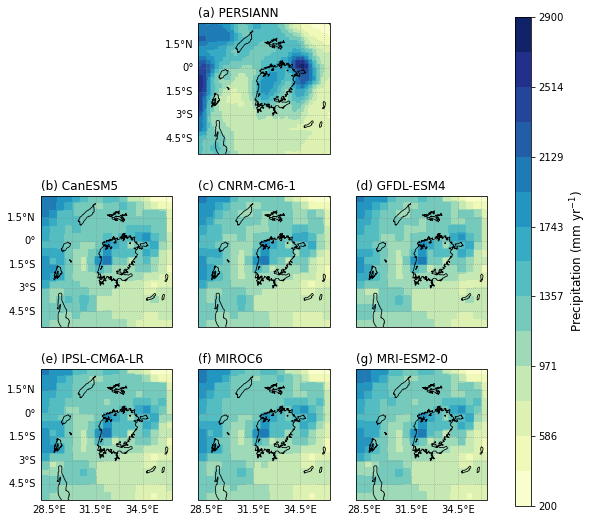

In [28]:

lon = PERSIANN_mean_yr.lon
lat = PERSIANN_mean_yr.lat

# Amount of plots
rs = 3
cs = 3

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree()
# Prepare colormap
cmap = 'YlGnBu'

# levels
lmin = float(GCM_raw[GCMs[1]].min().values)
lmax = float(PERSIANN_mean_yr.max().values)
levels = np.linspace(math.floor(lmin/100)*100,math.ceil(lmax/100)*100,15)

# units
label = 'Precipitation (mm yr$^{-1}$)'

# title
titlelist = ['(a) PERSIANN']
for i, char in zip(range(6), range_char("b", "g")):
    titlelist.append('({}) {}'.format(char, GCMs[i]))

# plot
fig = plt.figure(figsize = (10, 9), constrained_layout=False)

# n.1 : observations
ax1 = plt.subplot(rs, cs, 2, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax1, PERSIANN_mean_yr, titlelist[0], cmap, levels, label, bottom=False)

i = 0
ax2 = plt.subplot(rs, cs, 4, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax2, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label, bottom=False)

i = 1
ax3 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax3, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label, left=False, bottom=False)

i = 2
ax4 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax4, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label, left=False, bottom=False)

i = 3
ax5 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax5, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label)

i = 4
ax6 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax6, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label, left=False)

i = 5
ax7 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax7, GCM_raw[GCMs[i]], titlelist[i+1], cmap, levels, label, left=False)

axlist = [ax1, ax2,ax3,ax4,ax5,ax6,ax7]

cb = fig.colorbar(plot, cmap=cmap, ax=axlist, orientation='vertical', aspect=30)
cb.set_label(label=label, size=12)


#fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'GCMs_precip_mean_yr_{}_{}_nan.pdf'.format(start,end)),dpi=300)
#plt.savefig(os.path.join(fig_path,'GCMs_precip_mean_yr_{}_{}_nan.png'.format(start,end)),dpi=300)




In [29]:
fig_path

'/data/brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/figs'

In [30]:
print(lmin, lmax)

216.71142578125 2838.636474609375


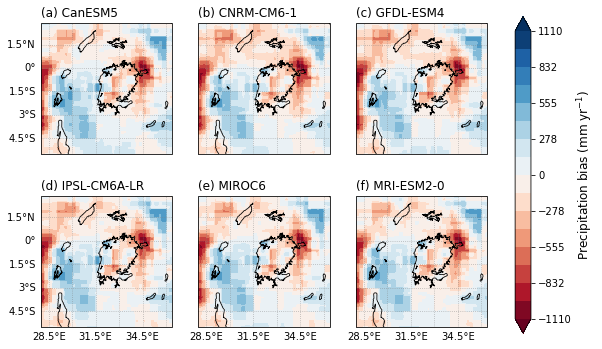

In [43]:

lon = PERSIANN_mean_yr.lon
lat = PERSIANN_mean_yr.lat

# Amount of plots
rs = 3
cs = 3

# Prepare projection
data_crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree()
# Prepare colormap
cmap = 'RdBu'

# levels
lmin = - max(abs(float((GCM_raw[GCMs[1]] - PERSIANN_mean_yr).min().values)) , abs(float((GCM_raw[GCMs[3]] - PERSIANN_mean_yr).max().values)))
lmax = max(abs(float((GCM_raw[GCMs[1]] - PERSIANN_mean_yr).min().values)) , abs(float((GCM_raw[GCMs[3]] - PERSIANN_mean_yr).max().values)))
levels = np.linspace(math.ceil(lmin/10)*10,math.floor(lmax/10)*10,17)

# units
label = 'Precipitation bias (mm yr$^{-1}$)'

# title
titlelist = ['(a) PERSIANN']
for i, char in zip(range(6), range_char("a", "f")):
    titlelist.append('({}) {}'.format(char, GCMs[i]))

# plot
fig = plt.figure(figsize = (10, 9),  constrained_layout=False)

i = 0
ax2 = plt.subplot(rs, cs, 4, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax2, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label=label, bottom=False)

i = 1
ax3 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax3, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label, left=False, bottom=False, extend='both')

i = 2
ax4 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax4, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label, left=False, bottom=False)

i = 3
ax5 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax5, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label)

i = 4
ax6 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax6, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label, left=False)

i = 5
ax7 = plt.subplot(rs, cs, 4+i, projection=ccrs.PlateCarree())
plot, cmap = plot_map(ax7, GCM_raw[GCMs[i]] - PERSIANN_mean_yr, titlelist[i+1], cmap, levels, label, left=False, extend='both')

axlist = [ax2,ax3,ax4,ax5,ax6,ax7]

cb = fig.colorbar(plot, cmap=cmap, ax=axlist, orientation='vertical', extend='both')
cb.set_label(label=label, size=12)


#fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'GCMs_precip_mean_yr_diff_{}_{}_nan.pdf'.format(start,end)),dpi=300)
#plt.savefig(os.path.join(fig_path,'GCMs_precip_mean_yr_diff_{}_{}_nan.png'.format(start,end)),dpi=300)




In [34]:
print(lmin,lmax)

-1118.70703125 1118.70703125


In [35]:
for i in range(len(GCMs)):
    GCM = GCMs[i]
    print(GCM, rmse(GCM_raw[GCMs[i]],PERSIANN_mean_yr)) 

# 1983 - 2020: rmse 270 - 286 mm/yr on average 

CanESM5 <xarray.DataArray ()>
array(277.33954, dtype=float32)
CNRM-CM6-1 <xarray.DataArray ()>
array(290.59412, dtype=float32)
GFDL-ESM4 <xarray.DataArray ()>
array(288.70117, dtype=float32)
IPSL-CM6A-LR <xarray.DataArray ()>
array(278.91782, dtype=float32)
MIROC6 <xarray.DataArray ()>
array(274.85178, dtype=float32)
MRI-ESM2-0 <xarray.DataArray ()>
array(272.582, dtype=float32)


## Part 2 : seasonality

1) Mask precip over basin+lake and calculate timeseries to compare climatologies for the period 1983-2014
2) Do it again for rcp370 2014-2020

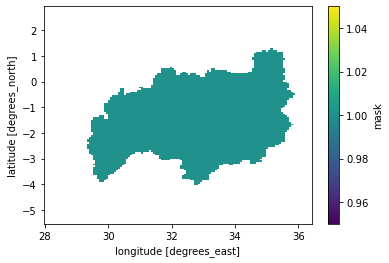

In [44]:
lon = PERSIANN_mean_yr.lon
lat = PERSIANN_mean_yr.lat

WBM_path = '/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/WBM/WBM_pythonversion_HPC/'
filepath_shp_basin = os.path.join(WBM_path,'input_data', 'shapefiles', 'Watsub.shp' ) 
basin_shp = gpd.read_file(filepath_shp_basin, crs="epsg:4326")
rmask_basinlake = regionmask.mask_geopandas(basin_shp, lon, lat) + 1 # lake+ basin set = 1

rmask_basinlake.plot()

In [45]:

def get_tseries(fileDIR, var, start, end, mask):
    with xr.open_dataset(fileDIR, engine='netcdf4') as ds:
        data = ds[str(var)].sel(time=slice('{}-01-01'.format(start), '{}-12-31'.format(end)))
        data = data.where(data > 0, 0) # remove neg
        
        if data.units == 'kg m-2 s-1': 
            print('units are kg m-2 s-1, converting them to kg m-2 d-1')
            data = data * 60 * 60 * 24
        else:
            print(data.units)
                
        data_basinlake = data.where(mask == 1) 
        data_monthly = data_basinlake.mean(dim=['lon','lat']).resample(time='M', label='right').sum()
        data_daily = data_basinlake.mean(dim=['lon','lat'])
    return data_monthly, data_daily

mm


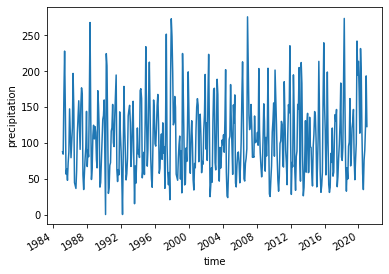

In [46]:
obs_month, obs_day = get_tseries(obsFILE, 'precipitation',start,end,rmask_basinlake)
obs_month.plot()


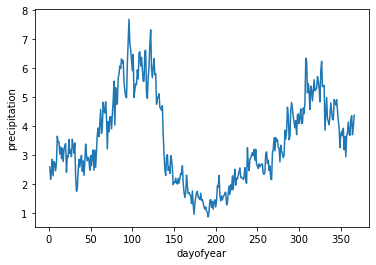

In [47]:
daily_climato = obs_day.groupby('time.dayofyear').mean('time')
daily_climato.plot()

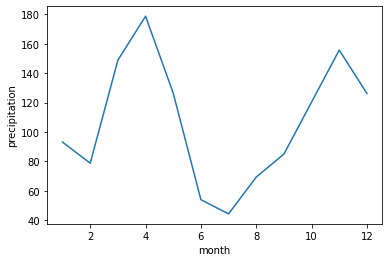

In [48]:
monthly_climato = obs_month.groupby('time.month').mean('time')
monthly_climato.plot()

In [49]:
GCM_month = {}
GCM_day = {}
var = 'pr'
#start = 1983 # to cfr w persiann
#end = 2020 # 2014

for i in range(len(GCMs)):
    GCM = GCMs[i]
    fileDIR=glob.glob(os.path.join(inDIR, GCM, '*_pr_owngrid*1850_{}.nc'.format(end)))[0]
    print(fileDIR)
    GCM_month["{}".format(GCM)] , GCM_day["{}".format(GCM)]= get_tseries(fileDIR, var,start,end,rmask_basinlake)   



/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/CanESM5/CanESM5_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/CNRM-CM6-1/CNRM-CM6-1_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/GFDL-ESM4/GFDL-ESM4_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/IPSL-CM6A-LR/IPSL-CM6A-LR_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/hist-rcp70/MIROC6/MIROC6_pr_owngrid_histrcp70_1850_2020.nc
units are kg m-2 s-1, converting them to kg m-2 d-1
/vscmnt

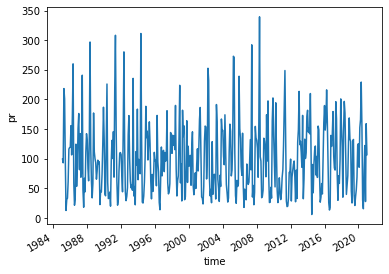

In [50]:
GCM_month[GCMs[i]].plot()

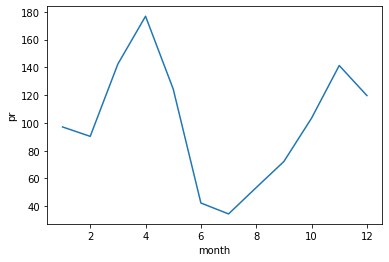

In [51]:
GCM_month[GCMs[i]].groupby('time.month').mean('time').plot()

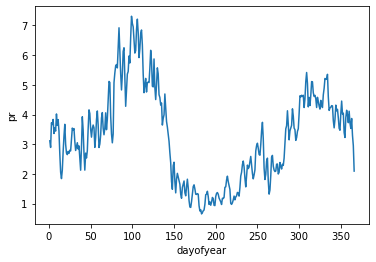

In [52]:
GCM_day[GCMs[i]].groupby('time.dayofyear').mean('time').plot()

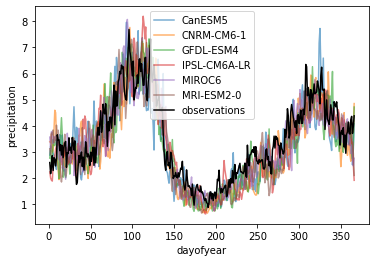

In [53]:
for i in range(len(GCMs)):
               GCM_day[GCMs[i]].groupby('time.dayofyear').mean('time').plot(alpha=0.6, label=str(GCMs[i]))

daily_climato = obs_day.groupby('time.dayofyear').mean('time')
daily_climato.plot(c='black', label='observations')
plt.legend()
plt.show()

In [54]:
#for i in range(len(GCMs)):
#               GCM_day[GCMs[i]].groupby('time.month').mean('time').plot(alpha=0.6, label=str(GCMs[i]))

#daily_climato = obs_day.groupby('time.month').mean('time')
#daily_climato.plot(c='black', label='observations')
#plt.legend()

#plt.show()

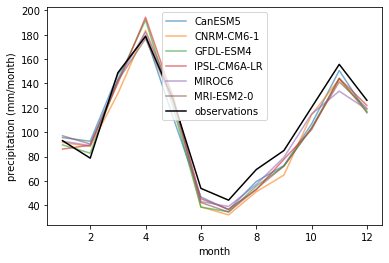

In [55]:
for i in range(len(GCMs)):
               GCM_month[GCMs[i]].groupby('time.month').mean('time').plot(alpha=0.6, label=str(GCMs[i]))

monthly_climato = obs_month.groupby('time.month').mean('time')
monthly_climato.plot(c='black', label='observations')
plt.legend()
plt.ylabel('precipitation (mm/month)')


plt.show()

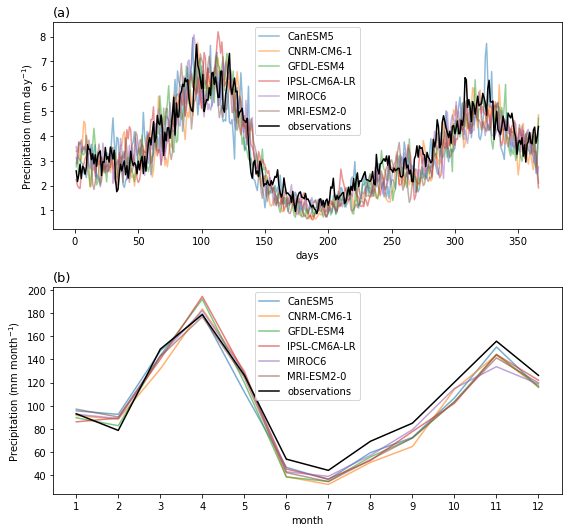

In [57]:
# Data

fig, axes = plt.subplots(2,1, figsize=(8,7.5))

ax=axes[0]
for i in range(len(GCMs)):
               GCM_day[GCMs[i]].groupby('time.dayofyear').mean('time').plot(alpha=0.5, label=str(GCMs[i]), ax=ax)
daily_climato = obs_day.groupby('time.dayofyear').mean('time')
daily_climato.plot(c='black', label='observations', ax=ax)
ax.legend()
ax.set_title('(a)', loc='left', size=13)
ax.set_ylabel('Precipitation (mm day$^{-1}$)')
ax.set_xlabel('days')


ax=axes[1]
for i in range(len(GCMs)):
               GCM_month[GCMs[i]].groupby('time.month').mean('time').plot(alpha=0.6, label=str(GCMs[i]))

monthly_climato = obs_month.groupby('time.month').mean('time')
monthly_climato.plot(c='black', label='observations')
ax.legend()
ax.set_title('(b)', loc='left', size=13)
ax.set_ylabel('Precipitation (mm month$^{-1}$)')
ax.set_xticks(range(1,13))

fig.tight_layout()

#plt.savefig(os.path.join(fig_path,'GCMs_hist_precip_basinlake_seasonality_{}_{}_nan.pdf'.format(start,end)),dpi=300)
#plt.savefig(os.path.join(fig_path,'GCMs_hist_precip_basinlake_seasonality_{}_{}_nan.png'.format(start,end)),dpi=300)


In [58]:
fig_path

'/data/brussel/vo/000/bvo00012/vsc10419/Thesis/ISIMIP3b/figs'